<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Brain_Tumor_Detection_using_YOLO_v10_and_SAM_sagittal_t1wce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Brain tumor object detection datasets](https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets)

## Refference

- [Brain Tumor Detection using YOLO v10](https://www.kaggle.com/code/metinmekiabullrahman/brain-tumor-detection-using-yolo-v10)
- [Brain_Tumor_Detection (SAM)](https://www.kaggle.com/code/giovanniimbesi/brain-tumor-detection)

## 0. Setting for Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
!pip install wandb
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

## [Early Stpopping](https://note.com/kiyo_ai_note/n/nac73b50f3b78)

In [3]:
'''
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
      #Saves model when validation loss decrease.
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
'''

'\nimport numpy as np\nimport torch\n\nclass EarlyStopping:\n    """Early stops the training if validation loss doesn\'t improve after a given patience."""\n    def __init__(self, patience=7, verbose=False, delta=0, path=\'checkpoint.pt\', trace_func=print):\n        """\n        Args:\n            patience (int): How long to wait after last time validation loss improved.\n                            Default: 7\n            verbose (bool): If True, prints a message for each validation loss improvement.\n                            Default: False\n            delta (float): Minimum change in the monitored quantity to qualify as an improvement.\n                            Default: 0\n            path (str): Path for the checkpoint to be saved to.\n                            Default: \'checkpoint.pt\'\n            trace_func (function): trace print function.\n                            Default: print\n        """\n        self.patience = patience\n        self.verbose = verbose\n      

In [4]:
import shutil
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/axial_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/coronal_t1wce_2_class.zip', './')
shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/sagittal_t1wce_2_class.zip', './')

In [5]:
files = os.listdir('./sagittal_t1wce_2_class/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00193_172


In [6]:
with open(os.path.join('./sagittal_t1wce_2_class/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

(512, 512, 3)


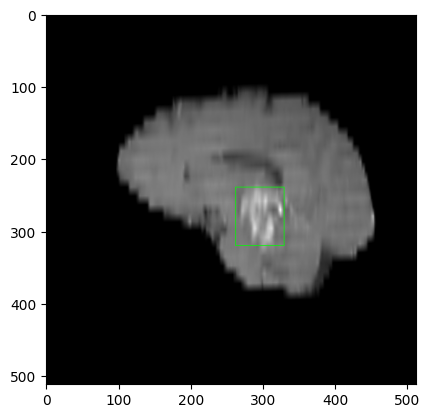

In [7]:
img = cv2.imread(os.path.join('./sagittal_t1wce_2_class/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [8]:
train_images = os.listdir('./sagittal_t1wce_2_class/images/train')
test_images = os.listdir('./sagittal_t1wce_2_class/images/test')
train_labels = os.listdir('./sagittal_t1wce_2_class/labels/train')
test_labels = os.listdir('./sagittal_t1wce_2_class/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

264 70
264 70


In [9]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('./sagittal_t1wce_2_class/images/train', image))

In [10]:
train_images = os.listdir('./sagittal_t1wce_2_class/images/train')
test_images = os.listdir('./sagittal_t1wce_2_class/images/test')
train_labels = os.listdir('./sagittal_t1wce_2_class/labels/train')
test_labels = os.listdir('./sagittal_t1wce_2_class/images/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

264 70
264 70


In [11]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('./sagittal_t1wce_2_class/images/val'):
    shutil.rmtree('./sagittal_t1wce_2_class/images/val')
if os.path.exists('./sagittal_t1wce_2_class/labels/val'):
    shutil.rmtree('./sagittal_t1wce_2_class/labels/val')

os.mkdir('./sagittal_t1wce_2_class/images/val')
os.mkdir('./sagittal_t1wce_2_class/labels/val')

for image in val_images:
    shutil.move(os.path.join('./sagittal_t1wce_2_class/images/train', image), './sagittal_t1wce_2_class/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('./sagittal_t1wce_2_class/labels/train', label), './sagittal_t1wce_2_class/labels/val')

In [12]:
text ="""
path: ../sagittal_t1wce_2_class
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""

with open('./fixed_path.yaml', 'w') as file:
    file.write(text)

In [13]:
model = YOLO('yolov10s.pt')

100%|██████████| 15.9M/15.9M [00:00<00:00, 125MB/s] 


In [14]:
#early_stopping = EarlyStopping()
results = model.train(data='./fixed_path.yaml', batch=-1, epochs=50, device=0)

Ultralytics YOLOv8.2.67 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10s.pt, data=./fixed_path.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 114MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.25G reserved, 0.10G allocated, 14.39G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     8067900       24.77         0.682         59.06           nan        (1, 3, 640, 640)                    list
     8067900       49.55         1.267          50.1           nan        (2, 3, 640, 640)                    list
     8067900        99.1         2.462         44.68           nan        (4, 3, 640, 640)                    list
     8067900       198.2         4.706         65.11           nan        (8, 3, 640, 640)                    list
     8067900       396.4         9.091         96.72           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 15 for CUDA:0 8.92G/14.75G (60%) ✅


train: Scanning /content/sagittal_t1wce_2_class/labels/train... 212 images, 0 backgrounds, 0 corrupt: 100%|██████████| 212/212 [00:00<00:00, 2383.37it/s]

train: New cache created: /content/sagittal_t1wce_2_class/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/sagittal_t1wce_2_class/labels/val... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<00:00, 1383.39it/s]

val: New cache created: /content/sagittal_t1wce_2_class/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00046875), 111 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.33G      3.432      37.79      3.111          9        640: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         52         55      0.242     0.0862       0.11     0.0721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.31G      2.662      15.87      2.432          4        640: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         52         55      0.101      0.176        0.1      0.068



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.28G      2.597      8.224      2.415          3        640: 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         52         55      0.225      0.332      0.204      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.32G      2.858      5.433      2.613          3        640: 100%|██████████| 15/15 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         52         55      0.101      0.247     0.0861     0.0478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.31G      2.865       4.29      2.521          5        640: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         52         55      0.328      0.378      0.231      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.31G      2.773      3.788        2.6          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         52         55      0.383      0.589      0.374      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.29G      2.685      3.881      2.505          7        640: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         52         55      0.395      0.479       0.32      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.33G      2.761      3.707      2.487          3        640: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         52         55      0.379       0.52      0.359      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.31G      2.948      3.401      2.716          1        640: 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         52         55       0.39      0.568      0.341      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.31G      2.778      3.076      2.453          4        640: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         52         55      0.349      0.312      0.217      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.29G      2.809      3.068      2.557          3        640: 100%|██████████| 15/15 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         52         55       0.46      0.513      0.376      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.32G      2.763      3.384       2.62          2        640: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         52         55      0.496      0.566       0.44      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.31G      2.612       3.13      2.547          2        640: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         52         55      0.346      0.601      0.404      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.31G      2.724      3.073      2.476          4        640: 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         52         55      0.351      0.386      0.297       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.29G      2.524      2.968      2.448          2        640: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         52         55      0.323      0.616      0.381      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.33G      2.527      2.969      2.487          3        640: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         52         55      0.417      0.599      0.426      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.31G      2.401      2.724      2.342          6        640: 100%|██████████| 15/15 [00:04<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         52         55       0.37      0.438      0.307      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.31G      2.459      2.694      2.495          1        640: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         52         55      0.477      0.612      0.467      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.29G      2.532      2.636      2.432          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         52         55      0.426      0.614      0.398      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.33G       2.41      2.707      2.353          3        640: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         52         55      0.452      0.609      0.452      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.31G      2.397      2.699      2.372          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         52         55      0.397      0.603      0.414      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.31G      2.549      2.627      2.397          4        640: 100%|██████████| 15/15 [00:04<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         52         55      0.414      0.766      0.455      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.29G      2.545      2.676       2.38          2        640: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         52         55      0.437      0.653      0.463      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.33G      2.346      2.594      2.258          5        640: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         52         55      0.412      0.704      0.477      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.31G      2.362      2.588      2.296          5        640: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         52         55      0.378      0.614       0.43      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.31G      2.167      2.482      2.193          1        640: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         52         55      0.396      0.779       0.42      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.29G      2.248      2.514      2.318          4        640: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         52         55      0.493      0.687       0.53      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.33G      2.111      2.411      2.204          1        640: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         52         55       0.45      0.802      0.458       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.31G      2.124      2.392       2.24          6        640: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         52         55      0.449      0.798      0.466      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.31G      2.009      2.379      2.202          2        640: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         52         55      0.462      0.742      0.481      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.29G       1.95      2.234      2.156          6        640: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         52         55      0.421      0.635      0.416      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.33G      2.103      2.303      2.176          3        640: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         52         55      0.459      0.674       0.48       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.31G      2.194      2.378      2.212          4        640: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         52         55      0.427      0.698       0.45      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.31G      2.024      2.244      2.151          3        640: 100%|██████████| 15/15 [00:04<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         52         55        0.4      0.733        0.5       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.29G       2.01      2.239      2.171          4        640: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         52         55      0.447        0.8      0.537      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.32G      1.878      2.098      2.116          2        640: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         52         55       0.42       0.81      0.522      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.31G      1.979      2.128      2.059          6        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         52         55      0.457      0.747      0.499      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.31G      1.941      2.144      2.106          6        640: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         52         55      0.439      0.772      0.489      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.29G      1.944      2.072      2.072          6        640: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         52         55      0.432      0.878      0.517      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.32G      1.899       2.08      2.097          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         52         55      0.415      0.743      0.508      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.31G      1.698      1.946      2.036          2        640: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         52         55      0.449      0.708      0.469      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.31G      1.653      1.881      1.926          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         52         55      0.454      0.762      0.471      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.29G      1.633      1.927      1.991          2        640: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         52         55      0.414       0.75      0.483      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.33G      1.704      1.935       2.04          3        640: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         52         55      0.448      0.791       0.48      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.31G      1.578       1.84      1.955          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         52         55      0.425       0.81      0.472      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.31G      1.577      1.785      1.924          2        640: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         52         55      0.434      0.788      0.475      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.29G      1.505      1.751      1.934          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         52         55      0.438      0.798      0.468      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.33G      1.448      1.775      1.849          2        640: 100%|██████████| 15/15 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         52         55      0.412       0.81       0.44      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.31G      1.463      1.698      1.887          2        640: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         52         55      0.415      0.766       0.43       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.31G      1.391      1.678       1.87          2        640: 100%|██████████| 15/15 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         52         55      0.411      0.798      0.447      0.333



50 epochs completed in 0.115 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 16.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.67 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8,036,508 parameters, 0 gradients, 24.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


                   all         52         55      0.411      0.738      0.509      0.376
              negative         28         29      0.423      0.707      0.485      0.369
              positive         24         26        0.4      0.769      0.532      0.384
Speed: 0.4ms preprocess, 7.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train


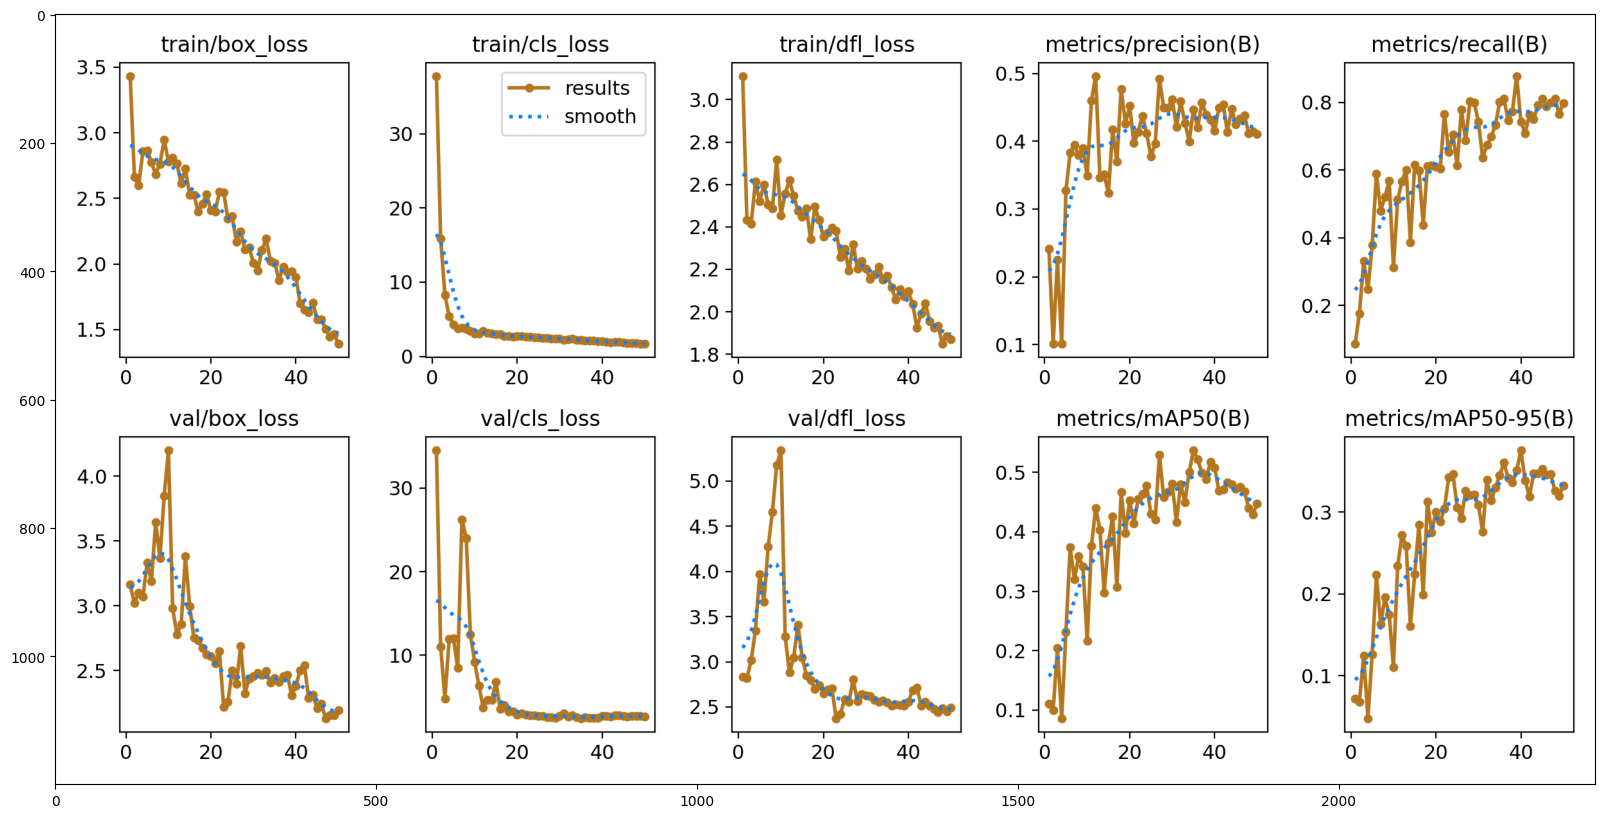

In [15]:
training_save_dir = './' + str(results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

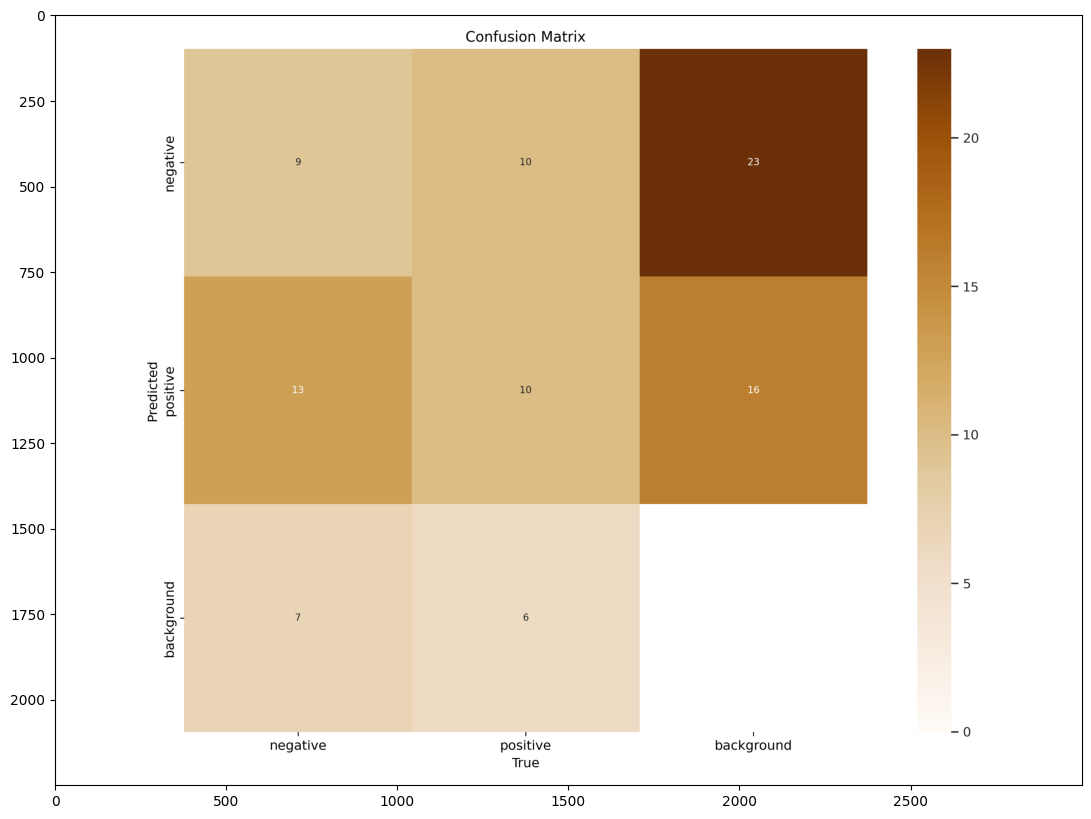

In [16]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

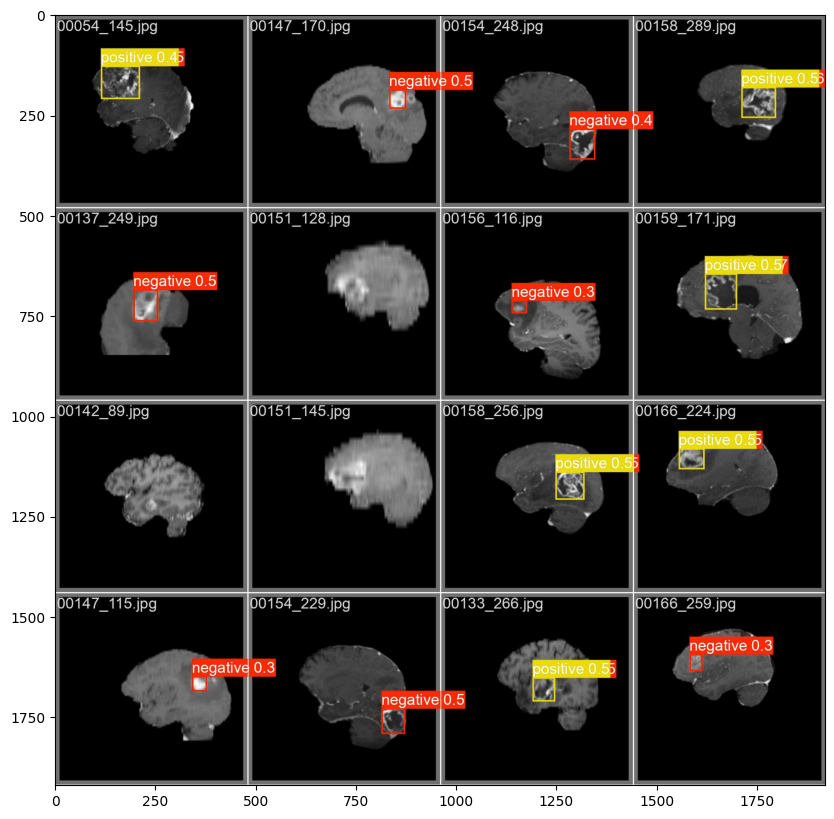

In [17]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

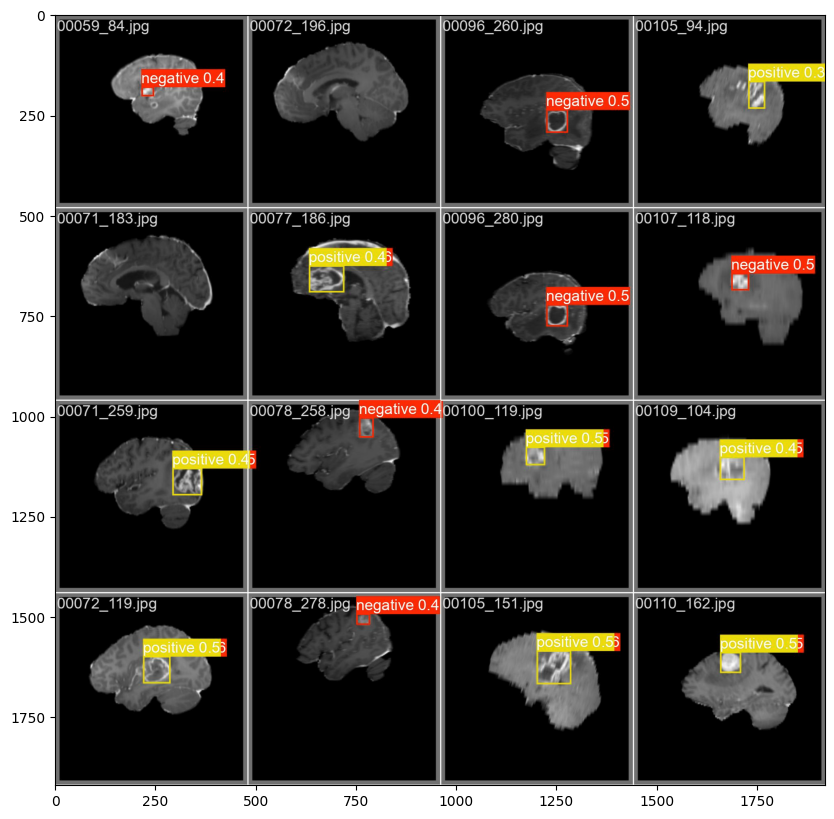

In [18]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

In [19]:
trained_model = YOLO(training_save_dir + '/weights/best.pt')
predictions = trained_model.predict(
    source="./sagittal_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/70 /content/sagittal_t1wce_2_class/images/test/00000_102.jpg: 640x640 1 negative, 1 positive, 59.2ms
image 2/70 /content/sagittal_t1wce_2_class/images/test/00000_121.jpg: 640x640 1 negative, 1 positive, 36.1ms
image 3/70 /content/sagittal_t1wce_2_class/images/test/00000_140.jpg: 640x640 1 negative, 35.6ms
image 4/70 /content/sagittal_t1wce_2_class/images/test/00000_159.jpg: 640x640 (no detections), 59.5ms
image 5/70 /content/sagittal_t1wce_2_class/images/test/00002_110.jpg: 640x640 1 negative, 1 positive, 36.5ms
image 6/70 /content/sagittal_t1wce_2_class/images/test/00002_129.jpg: 640x640 1 negative, 1 positive, 25.3ms
image 7/70 /content/sagittal_t1wce_2_class/images/test/00002_147.jpg: 640x640 1 negative, 1 positive, 21.8ms
image 8/70 /content/sagittal_t1wce_2_class/images/test/00002_166.jpg: 640x640 1 negative, 1 positive, 19.5ms
image 9/70 /content/sagittal_t1wce_2_class/images/test/00003_154.jpg: 640x640 1 negative, 1 positive, 18.6ms
image 10/70 /content/sagittal_t1wce_2

In [20]:
predictions_save_dir = './' + predictions[0].save_dir + '/labels'

In [21]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['1', '0.37868', '0.493145', '0.0892248', '0.10541', '0.537469\n']
['1', '0.378521', '0.490023', '0.095070', '0.099765']


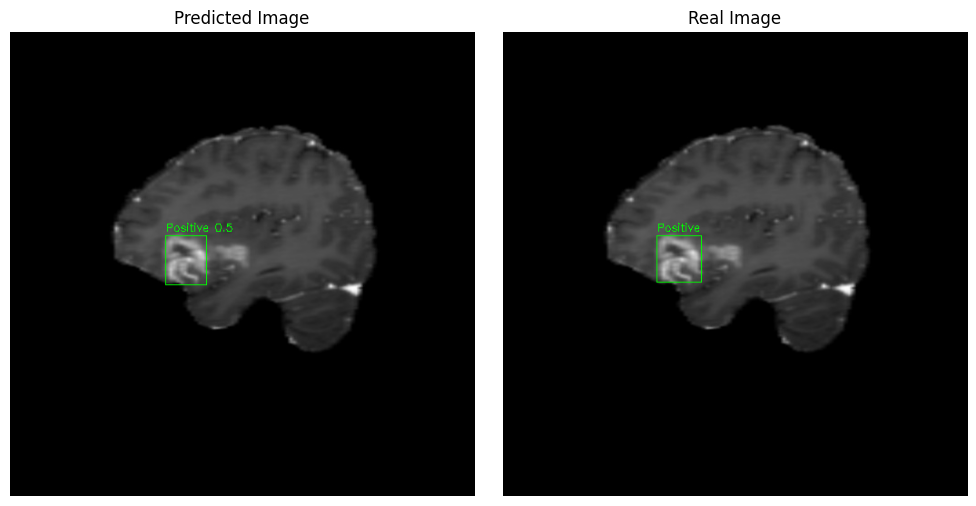

In [22]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('./sagittal_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('./sagittal_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('./sagittal_t1wce_2_class/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [23]:
text = """
path: ../sagittal_t1wce_2_class
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [24]:
metrics = trained_model.val(data="./test.yaml")

Ultralytics YOLOv8.2.67 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/sagittal_t1wce_2_class/labels/test... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 900.07it/s]

val: New cache created: /content/sagittal_t1wce_2_class/labels/test.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


                   all         70         77      0.488      0.754      0.482      0.349
              negative         35         39      0.473      0.718      0.443      0.304
              positive         35         38      0.503      0.789       0.52      0.393
Speed: 0.8ms preprocess, 37.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val


In [25]:
test_save_dir = './' + str(metrics.save_dir)

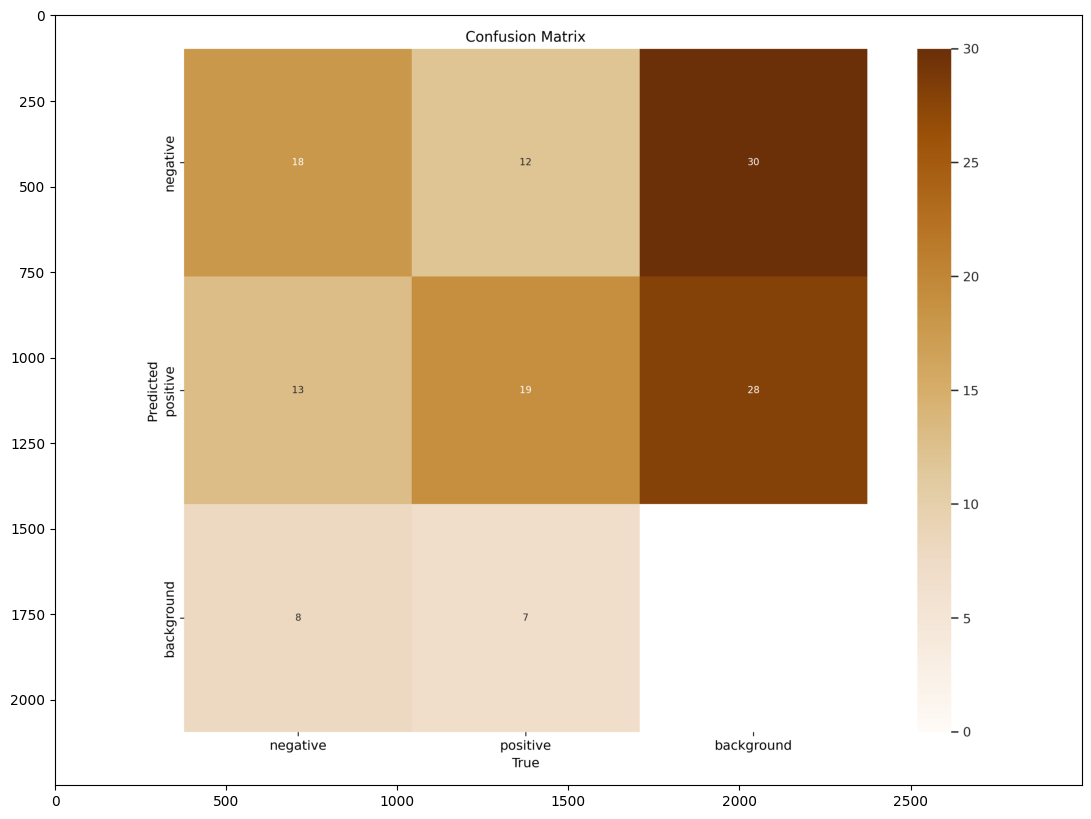

In [26]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

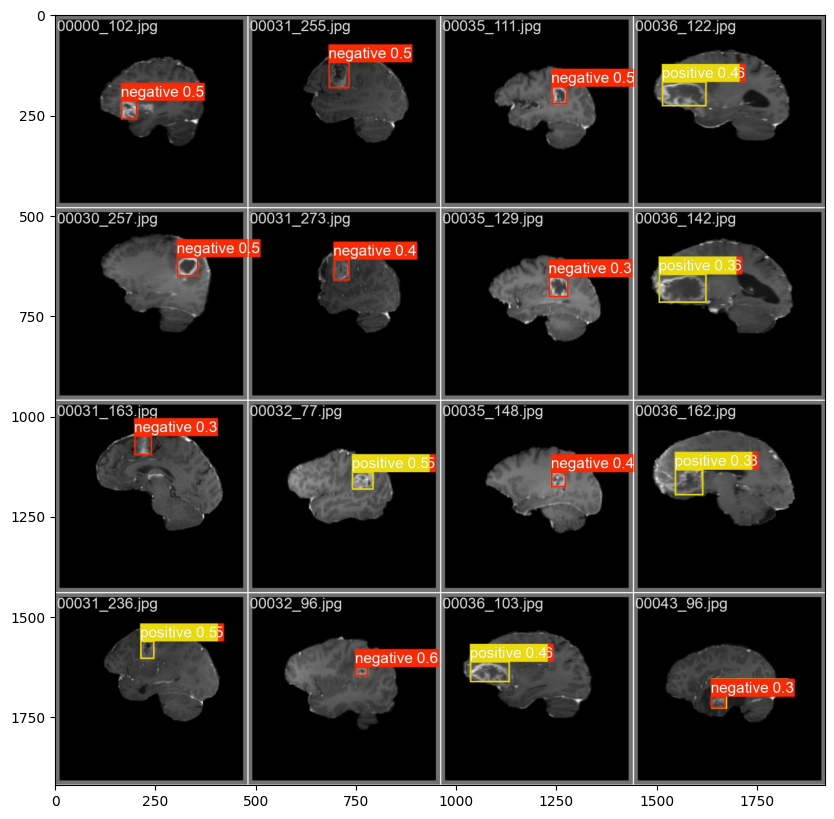

In [27]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

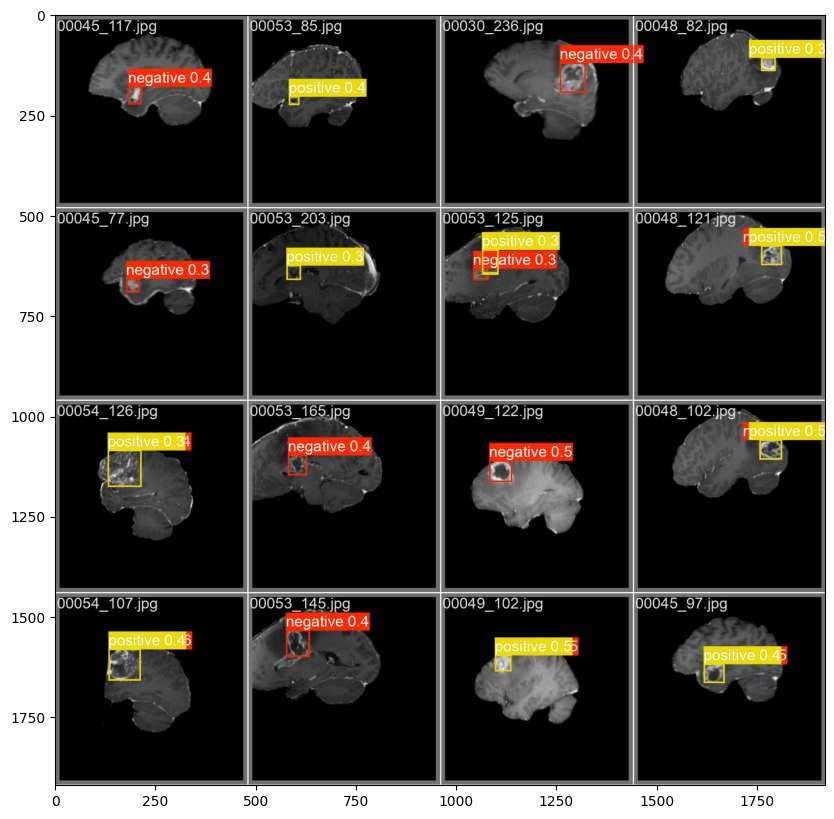

In [28]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

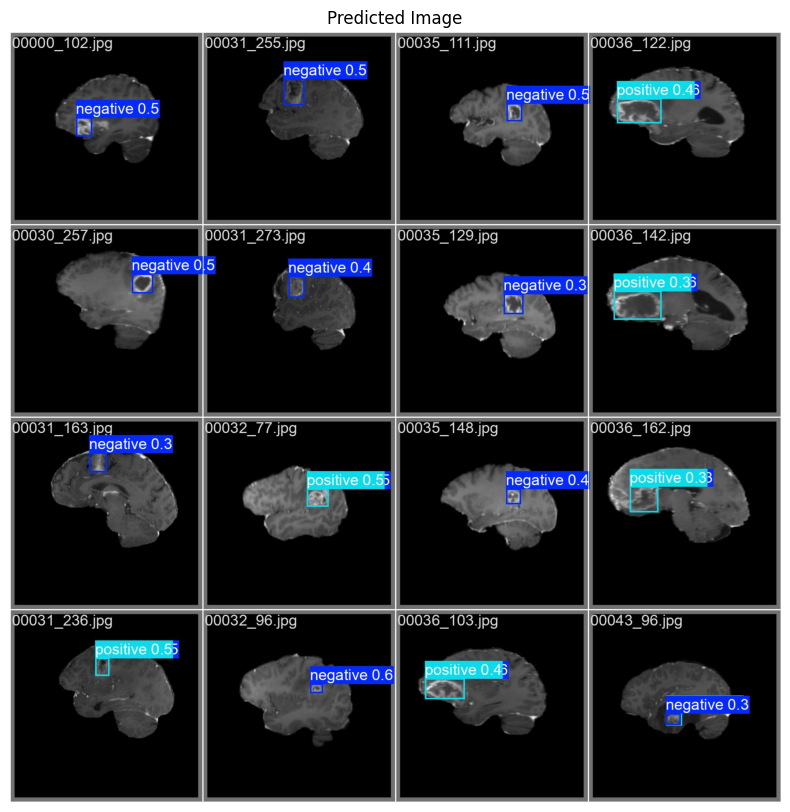

In [29]:
image_path = os.path.join(test_save_dir, 'val_batch0_pred.jpg')

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Read the image using OpenCV
img = cv2.imread(image_path)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display

# Add a title to the plot (optional)
plt.title('Predicted Image')

# Show the plot
plt.axis('off')  # Hide axis ticks and labels
plt.show()

## [SAM(Segment Anything Model)](https://segment-anything.com/)

In [30]:
real_path = os.path.join('./sagittal_t1wce_2_class/images/test', f'{random_file}.jpg')

In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [32]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-dtgynv9z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-dtgynv9z
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36591 sha256=61ab2179d78165067f1aad4c31024548cafd04f436076a4d7d1c975d8e1f1b1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-65i1aepb/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [33]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: line 1: {sys.executable}: command not found
--2024-07-28 01:35:30--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.96, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  34.5MB/s    in 30s     

2024-07-28 01:36:00 (81.8 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [34]:
image = cv2.cvtColor(cv2.imread(real_path), cv2.COLOR_BGR2RGB)
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = 0
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [35]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [36]:
model=YOLO('./runs/detect/train/weights/best.pt')
results = model.predict(source=real_path, conf=0.25)
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]


image 1/1 /content/sagittal_t1wce_2_class/images/test/00000_102.jpg: 640x640 1 negative, 1 positive, 22.0ms
Speed: 55.8ms preprocess, 22.0ms inference, 26.8ms postprocess per image at shape (1, 3, 640, 640)


In [37]:
print(bbox)

[171.04263305664062, 225.50527954101562, 216.7257537841797, 279.4751892089844]


In [38]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:199: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  y_embed = grid.cumsum(dim=0) - 0.5
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:200: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  x_embed = grid.cumsum(dim=1) - 0.5


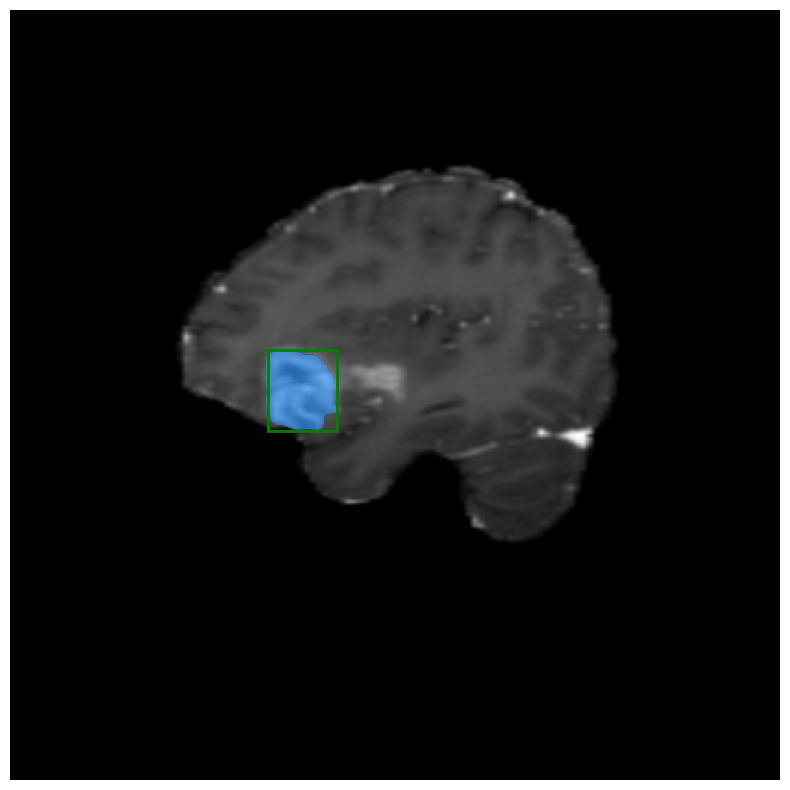

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()